In [1]:
from SimPEG import *
from simpegEM1D import (
    EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, 
    set_mesh_1d, skytem_LM_2015
)
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
def compute_response(use_lowpass_filter):
#     input_currents = np.r_[0.0000E+00,6.3431E-02,2.4971E-01,4.7453E-01,8.9044E-01,1.0000E+00,1.0000E+00,9.7325E-01,7.9865E-01,5.3172E-01,2.7653E-01,1.5062E-01,7.5073E-02,3.1423E-02,7.9197E-03,0.0000E+00]
#     time_input_currents = np.r_[-8.0000E-04,-7.6473E-04,-6.2818E-04,-4.3497E-04,-9.2197E-05,-2.0929E-06,6.6270E-08 ,6.9564E-07 ,2.1480E-06 ,3.7941E-06 ,5.6822E-06 ,7.1829E-06 ,8.5385E-06 ,1.0136E-05 ,1.1976E-05 ,1.3138E-05]
    time_input_currents = np.r_[-8.0000E-04,-7.6473E-04,-6.2818E-04,-4.3497E-04,-9.2197E-05,-2.0929E-06,6.6270E-08 ,6.9564E-07 ,2.1480E-06 ,3.7941E-06 ,5.6822E-06 ,7.1829E-06 ,8.5385E-06 ,1.0136E-05 ,1.1976E-05 ,1.3138E-05]
    input_currents = np.r_[0.0000E+00, 6.3431E-02, 2.4971E-01, 4.7453E-01, 8.9044E-01, 1.0000E+00,1.0000E+00,9.7325E-01,7.9865E-01,5.3172E-01,2.7653E-01,1.5062E-01,7.5073E-02,3.1423E-02,7.9197E-03,0.0000E+00]
#     time = np.loadtxt("Skytem_LM_time_gates_Mike.txt", skiprows=1)[:, -2]*1e-6 - time_input_currents[-1]
    time = np.r_[ 3.179659e-06, 7.651805e-06, 1.312977e-05, 2.006194e-05, 2.900623e-05, 4.040942e-05, 5.483263e-05, 7.272122e-05, 9.508194e-05, 1.229211e-04, 1.581381e-04, 2.033051e-04, 2.599911e-04, 3.314300e-04, 4.218804e-04, 5.351367e-04, 6.781304e-04, 8.584694e-04]
    hz = get_vertical_discretization_time(time, facter_tmax=0.5, factor_tmin=10.)
    mesh1D = set_mesh_1d(hz)
    depth = -mesh1D.gridN[:-1]
    LocSigZ = -mesh1D.gridCC
    wave_type = "skytem"
    # time_input_currents = wave.current_times[-13:]
    # input_currents = wave.currents[-13:]
    TDsurvey = EM1DSurveyTD(
        rx_location = np.array([0., 0., 100.+35.]),
        src_location = np.array([0., 0., 100.+35.]),
        topo = np.r_[0., 0., 100.],
        depth = depth,
        rx_type = 'dBzdt',
        wave_type = 'general',
        src_type = 'CircularLoop',
        a = 10.357,
        I = 1.,
        time = time,
        time_input_currents=time_input_currents,
        input_currents=input_currents,
        n_pulse = 1,
        base_frequency = 25.,
        use_lowpass_filter=use_lowpass_filter,
        high_cut_frequency=210*1e3
    )

    sig_half = 1./1.
    sig_blk = 1./1.
    chi_half = 0.
    sig  = np.ones(TDsurvey.n_layer)*sig_half
    blk_ind = (-30>LocSigZ) & (-70<LocSigZ)
    sig[blk_ind] = sig_blk
    m_true = np.log(sig)    
    expmap = Maps.ExpMap(mesh1D)

    prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
    if prob.ispaired:
        prob.unpair()
    if TDsurvey.ispaired:
        TDsurvey.unpair()
    prob.pair(TDsurvey)
    prob.chi = np.zeros(TDsurvey.n_layer)
    d_true = TDsurvey.dpred(m_true)    
    return d_true, sig, mesh1D

In [9]:
d0,_,mesh1D = compute_response(False)
d1,sig,_ = compute_response(True)

In [10]:
import matplotlib
matplotlib.rcParams['font.size'] = 16
time = np.r_[ 3.179659e-06, 7.651805e-06, 1.312977e-05, 2.006194e-05, 2.900623e-05, 4.040942e-05, 5.483263e-05, 7.272122e-05, 9.508194e-05, 1.229211e-04, 1.581381e-04, 2.033051e-04, 2.599911e-04, 3.314300e-04, 4.218804e-04, 5.351367e-04, 6.781304e-04, 8.584694e-04]

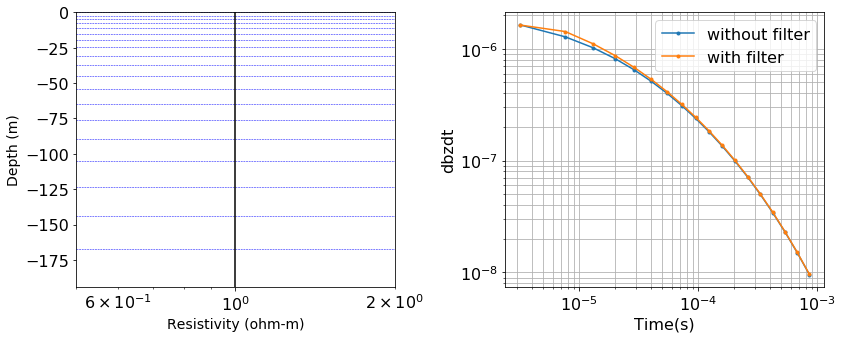

In [11]:
fig, axs = subplots(1,2, figsize=(12, 5))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=True, ax=axs[0])
axs[0].set_xlabel("Resistivity (ohm-m)")
axs[1].plot(time, -d0, '.-')
axs[1].plot(time, -d1, '.-')
axs[1].set_xscale('log');
axs[1].set_yscale('log');
axs[1].set_xlabel("Time(s)")
axs[1].set_ylabel("dbzdt")
axs[1].grid(which='both')
axs[1].legend(("without filter", "with filter"))
plt.tight_layout()

In [12]:
data = np.c_[time, -d0, -d1]

In [13]:
np.savetxt('em1d_fwd.csv', data, header="time, dbzdt (without filter), dbzdt (with filter)", delimiter=',')